


* https://docs.nvidia.com/deeplearning/dali/user-guide/docs/operations/nvidia.dali.fn.html
* https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/nnUNet/data_loading/dali_loader.py

* https://docs.nvidia.com/deeplearning/dali/user-guide/docs/FAQ.html#q-are-there-any-examples-of-using-dali-for-volumetric-data
* https://developer.nvidia.com/blog/accelerating-medical-image-processing-with-dali/ 


* Basic DALI tutorial : 


# 1. Basic DALI tutorial (https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/getting_started.html)  

## 1.1. Data Processing Pipeline
* mulitple operations connected to a directed raph and contained in an object class `nvidia.dali.Pipeline`
    * this class provided methods necessary for defining/building/running the data processing pipeline

In [4]:
from nvidia.dali.pipeline import Pipeline

### 1.1.1. Defining the Pipeline

In [22]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

image_dir = "./data/images"
max_batch_size = 8

@pipeline_def #decorate with pipeline_def 
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root = image_dir) #read the file
    images = fn.decoders.image(jpegs, device = 'cpu')  #decoede it 
    
    return images, labels

### 1.1.3. Building the Pipeline

in order to use the "simple_pipeline" we defined above, we need to **create** and **build** it => by 
* calling simple_pipeline ==>  creates an instance of the pipeline
* building it via `.build()` 



In [6]:
pipe = simple_pipeline(batch_size = max_batch_size, num_threads = 1, device_id = 0) #instantiating the pipeline
pipe.build() #bulding the pipeline

notice that simple_pipeline에 원래 input이 없었는데, `@pipeline_def`때문에, device_id같은 것들이 붙었다!
these can control : 
* max batch size
* \# of cpu threads to use
* which gpu to use (device ID)
* seed for random num generation

### 1.1.4. Running the Pipeline
* `pipe.run()`으로 run시킨다! 

앞에서 simple_pipeline할때, image cpu loading에 로딩하는 것 밖에 안했으니, 그것만 할듯 (실제로 그럼)

즉, `return images, labels` 였으니, images/labels (type : `TensorListCPU`) tuple 을 return 한다
* `TensorListCPU` : "list" of CPU Tensors (thereofre the tensors themselves don't have to be the same shape)

In [7]:
pipe_out = pipe.run()
print(pipe_out)
#print(type(pipe_out))
#print(type(pipe_out[0]),'\n', (pipe_out[0].shape))
#print(type(pipe_out[1]),'\n', pipe_out[1])

(TensorListCPU(
    [[[[255 255 255]
      [255 255 255]
      ...
      [ 86  46  55]
      [ 86  46  55]]

     [[255 255 255]
      [255 255 255]
      ...
      [ 86  46  55]
      [ 86  46  55]]

     ...

     [[158 145 154]
      [158 147 155]
      ...
      [ 93  38  41]
      [ 93  38  41]]

     [[157 145 155]
      [158 146 156]
      ...
      [ 93  38  41]
      [ 93  38  41]]]


    [[[ 69  77  80]
      [ 69  77  80]
      ...
      [ 97 105 108]
      [ 97 105 108]]

     [[ 69  77  80]
      [ 70  78  81]
      ...
      [ 97 105 108]
      [ 97 105 108]]

     ...

     [[199 203 206]
      [199 203 206]
      ...
      [206 210 213]
      [206 210 213]]

     [[199 203 206]
      [199 203 206]
      ...
      [206 210 213]
      [206 210 213]]]


    ...


    [[[ 26  28  25]
      [ 26  28  25]
      ...
      [ 34  39  33]
      [ 34  39  33]]

     [[ 26  28  25]
      [ 26  28  25]
      ...
      [ 34  39  33]
      [ 34  39  33]]

     ...

     [[ 35  46  30]

이것을 `TensorListCPU`를 np 로 바꿔서 보자

=> 항상할 수 있는 것은 아니다. np 랑 달리 TensorListCPU can hold tensors with diff shapes => thereofre, need to check `is_dense_tensor` 

In [9]:
images, labels = pipe_out #i.e. tuple을 images, labels 로 분리 
print("Images is_dense_tensor: " + str(images.is_dense_tensor()))
print("Labels is_dense_tensor: " + str(labels.is_dense_tensor()))

Images is_dense_tensor: False
Labels is_dense_tensor: True


따라서, labels만 ndarray 로바꾸기 가능! (하는것은 생략)

### 1.1.5. Actually looking at the images
* `i`th image 보는 법 => `image.at(j)` (ndarray 로됨)

In [14]:
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

def show_images(image_batch) : 
    """
    * image_batch : TensorlistCPU (batch of images)
    """
    
    columns = 4
    rows = (max_batch_size+1)//(columns)
    fig = plt.figure()
    gs = gridspec.GridSpec(rows,columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis('off')
        plt.imshow(image_batch[j]) ##this line is key (fetches the data)

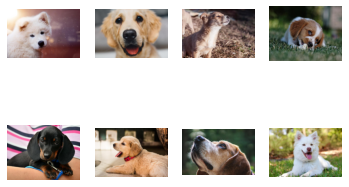

In [16]:
show_images(images)

## 1.2. Adding Augmentations
> `@pipeline_def` 에서 할때 `fn` 의 methods들을 넣어주면 됨

### 1.2.1. Random Shuffle / Random Rotate (둘다 하기)
* Shuffle : batch만들대 shuffle하도록 하는 것
* Random rotate : randomly rotate the image

밑에서 주의 : `angle` 은 DALI operator로 만든 것인데, 다른 operator의 input으로 들어가는 것을 볼 수 있다 => 이때, **다른 operator에 input(argument)으로 들어갈때 무조건 CPU에 그 argument가 있어야한다!)**

(`fn.random.uniform`은 by default, sends to cpu)

In [32]:
@pipeline_def
def random_rotated_pipeline():
    jpegs, labels = fn.readers.file(file_root = image_dir, 
                                    random_shuffle = True, #we add random shuffle!
                                    initial_fill = 21) #capacity of the buffer (buffer size..?)(크게 걱정안해도될듯)
    images = fn.decoders.image(jpegs, device = 'cpu')
    angle = fn.random.uniform(range = (-10.0, 10.0)) #generate random number (angle)
    rotated_images = fn.rotate(images, angle = angle, fill_value = 0 ) #rotate by that random angel value 

    return rotated_images, labels

In [35]:
#now let's (remember) 
#1. instantiate the pipeline
pipe = random_rotated_pipeline(batch_size = max_batch_size, num_threads = 1, device_id = 0, seed = 42) #remember, the arguments are from the wrapping
#2. build the pipelien
pipe.build()
#3. run the pipeline and retrieve the images and labels
images , labels = pipe.run()

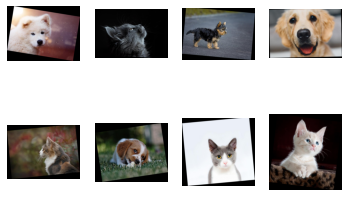

In [37]:
show_images(images)

### 1.3. Adding GPU acceleration

> `images.gpu()`로 gpu로 보낸다!

> `images.as_cpu()`로 cpu로 COPY 한다!


주의 : 현재 DALI는 **pipelines내에서** gpu->cpu로 보내는 것을 못함!

따라서, pipeline초기에 cpu => gpu로 가거나, pipeline을 다 빠져나온 후, gpu => cpu로 해야함

In [69]:
@pipeline_def
def random_rotated_gpu_pipeline():
    jpegs, labels = fn.readers.file(file_root = image_dir, 
                                    random_shuffle = True, #we add random shuffle!
                                    initial_fill = 21) #capacity of the buffer (buffer size..?)(크게 걱정안해도될듯)
    images = fn.decoders.image(jpegs, device = 'cpu')
    angle = fn.random.uniform(range = (-10.0, 10.0)) #generate random number (angle)
    rotated_images = fn.rotate(images.gpu(), angle = angle, fill_value = 0 ) #rotate by that random angel value 

    return rotated_images, labels

In [70]:
#now let's (remember) 
#1. instantiate the pipeline
pipe = random_rotated_gpu_pipeline(batch_size = max_batch_size, num_threads = 1, device_id = 0, seed = 42) #remember, the arguments are from the wrapping
#2. build the pipelien
pipe.build()
#3. run the pipeline and retrieve the images and labels
images , labels = pipe.run()

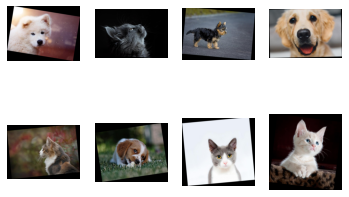

In [71]:
#show_images(images) #작동안함!! gpu에서 다시 cpu로 가져와야해서!
show_images(images.as_cpu())

## 1.4. Hybird Decoding : 생략 (jpeg decoding을 gpu의 도움으로 더 빠르게 할 수 있다는데, 우리는 안쓸듯)

## 1.5. (my writing) Trying other stuff

In [72]:
import nvidia.dali.types as types

@pipeline_def
def new_gpu_pipeline():
    jpegs, labels = fn.readers.file(file_root = image_dir, 
                                    random_shuffle = True, #we add random shuffle!
                                    initial_fill = 21) #capacity of the buffer (buffer size..?)(크게 걱정안해도될듯)
    images = fn.decoders.image(jpegs, device = 'cpu')
    angle = fn.random.uniform(range = (-10.0, 10.0)) #generate random number (angle)
    rotated_images = fn.rotate(images.gpu(), angle = angle, fill_value = 0 ) #rotate by that random angel value 
    converted = fn.brightness_contrast(rotated_images, 
                                      brightness_shift=0.3,
                                       contrast=0.8,
                                       contrast_center=100)
    converted = fn.color_space_conversion(converted, image_type = types.RGB, output_type = types.YCbCr)
    
    return converted, labels

In [73]:
#now let's (remember) 
#1. instantiate the pipeline
pipe = new_gpu_pipeline(batch_size = max_batch_size, num_threads = 1, device_id = 0, seed = 42) #remember, the arguments are from the wrapping
#2. build the pipelien
pipe.build()
#3. run the pipeline and retrieve the images and labels
images , labels = pipe.run()

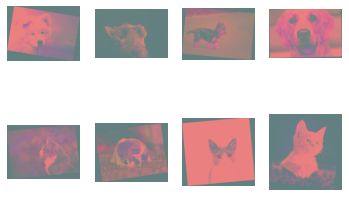

In [74]:
#show_images(images) #작동안함!! gpu에서 다시 cpu로 가져와야해서!
show_images(images.as_cpu())

참고로, (https://docs.nvidia.com/deeplearning/dali/user-guide/docs/pipeline.html#nvidia.dali.Pipeline) 

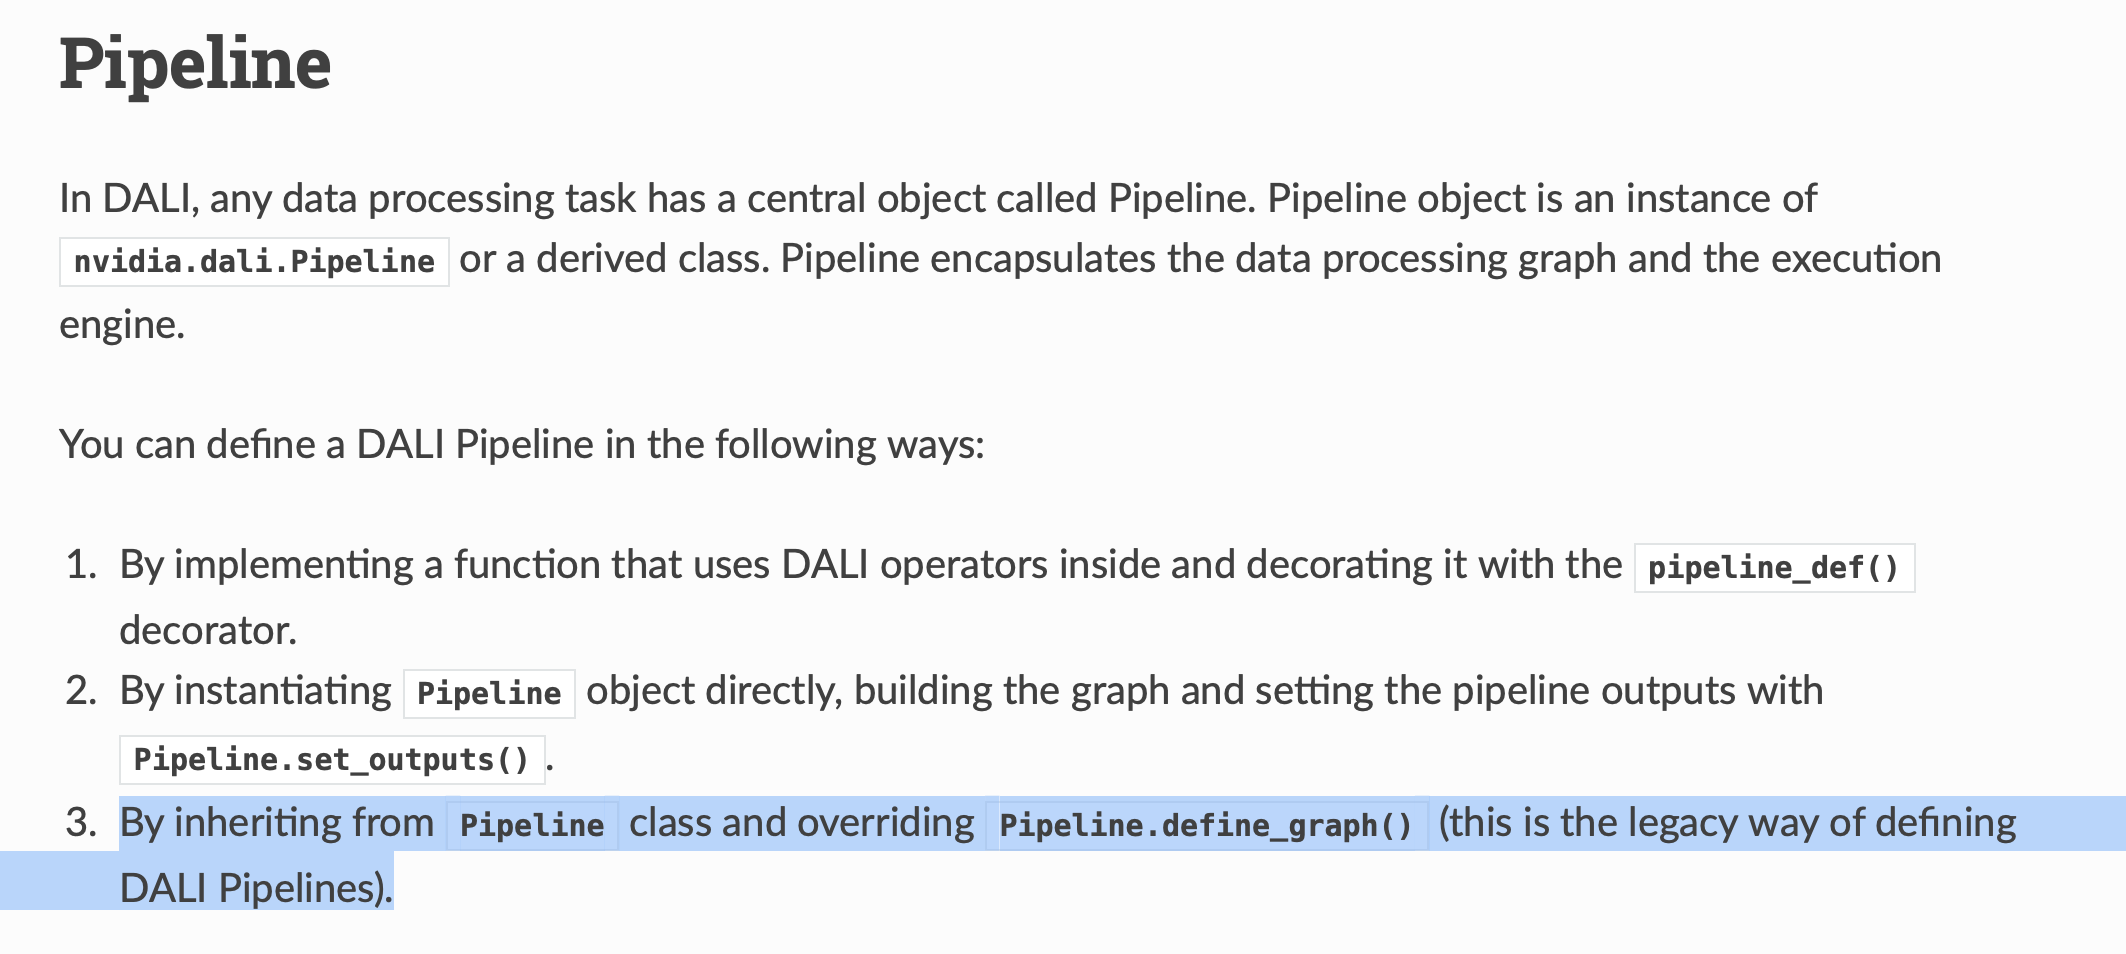
위에서 보듯이, 지금 튜토리얼은 1.으로 pipeline만드는데, 그 3D morph 그 거는 3번 (legacy method)로 pipeline을 만듬